## Labeling

*Taken from `fun with TF-IDF vectors.ipynb`*

In [1]:
from pandas import read_pickle, DataFrame
import geopandas
import pickle
import random
from wikiparse import pipeline_utils as utils

In [2]:
from pathlib import Path
from wikiparse import config

xml_filename = config.xml
scratch_folder = Path(config.folder)

In [3]:
import time
pipeline_start = time.time()

In [4]:
gdf = read_pickle(scratch_folder/'gdf_clusters.pkl')
gdf['tf_idf'] = gdf.tf_idf.astype('float64')

In [5]:
gdf.sample(5)

word tf                              article    df    tf_idf  \
23434071  arctic  1           Bolton Lake (Saskatchewan)  3225  0.000310   
22081450   knife  2                                 Kail   794  0.002519   
7060417   umpqua  1  Tenmile Creek (Coos County, Oregon)   135  0.007407   
23747120    1833  1   Xi Chapter, Psi Upsilon Fraternity  3740  0.000267   
20527119   ḩamīd  1                Amid, West Azerbaijan    14  0.071429   

                             geometry         lon        lat  cluster_193  \
23434071  POINT (-108.68389 57.56667) -108.683889  57.566667          111   
22081450     POINT (7.24361 50.18500)    7.243611  50.185000          102   
7060417   POINT (-124.23194 43.56167) -124.231944  43.561667           47   
23747120   POINT (-72.65500 41.55667)  -72.655000  41.556667            1   
20527119    POINT (45.65806 36.58000)   45.658056  36.580000           24   

          cluster_2000  cluster_10000  cluster_7  
23434071          1203           5462          0  
22081450          1771           3884          5  
7060417           1986           4650          0  
23747120          1210           9231          0  
20527119          1212           9561          2

In [6]:
def label_filter(label):
    for c in '1234567890_':
        if c in label:
            return False
    return True

In [7]:
gdf.tf_idf

1           0.133333
2           0.016393
3           0.015625
4           0.012821
5           0.003008
              ...   
26598489    0.000072
26598490    0.000070
26598491    0.000069
26598492    0.000068
26598493    0.000065
Name: tf_idf, Length: 25504108, dtype: float64

In [8]:
def get_center(gdf):
    geom  = gdf.geometry
    return (geom.map(lambda x: x.x).mean(), geom.map(lambda x: x.y).mean())

In [9]:
start = time.time()
cluster_labels = {}
centers = {}
already_used = set()
gdf['ones'] = 1

for zoom_level in ['7', '193', '2000', '10000']:
    cluster_labels[zoom_level] = {}
    centers[zoom_level] = {}

    if zoom_level in ['2000']: already_used = set()
    
    cluster_name = 'cluster_' + zoom_level

    for cluster_num in gdf[cluster_name].unique():
        idx = 0
        
        article_count = len(gdf[gdf[cluster_name] == cluster_num])
        most_common_words = gdf[gdf[cluster_name] == cluster_num]\
            .groupby(by='word').sum().sort_values(by='tf_idf', ascending=False)
        while idx < len(most_common_words.index) and \
            (most_common_words.index[idx] in already_used or not label_filter(most_common_words.index[idx])):
            idx += 1
        if idx == len(most_common_words.index): idx = random.randint(0, int(len(most_common_words.index)/4))
        label = most_common_words.index[idx]
        
        already_used.add(label)
        count = most_common_words.ones[idx]
        cluster_labels[zoom_level][int(cluster_num)] = label
        centers[zoom_level][int(cluster_num)] = get_center(gdf[gdf[cluster_name] == cluster_num])

        
    print('done with', zoom_level, round((time.time()-start)/60, 1), 'minutes so far')

done with 7 9.7 minutes so far
done with 193 19.8 minutes so far
done with 2000 33.6 minutes so far
done with 10000 62.6 minutes so far


In [10]:
def save_pickle(fname, obj):
    with open(fname, 'wb') as f:
        f.write(pickle.dumps(obj))
save_pickle(scratch_folder/'cluster_labels.pkl', cluster_labels)
save_pickle(scratch_folder/'centers.pkl', centers)

In [11]:
for zoom_level in ['7', '193', '2000', '10000']:
    labels = []
    for idx,word in cluster_labels[zoom_level].items():
        labels.append((word.capitalize(), centers[zoom_level][idx][1], centers[zoom_level][idx][0]))
    DataFrame(labels, columns=['label', 'lat', 'lon']).to_csv(scratch_folder/f'labels_{zoom_level}.csv')

I'm using the "most distinctive" method, where I sum the TF-IDF scores of each word and choose the one with the highest. So, if a word occurs in only a few articles in that group but each time the signal or TF-IDF score is high, it could end up being the label for the entire region. This leads to extremely obscure labels for a lot of regions, some of which you might know if you know the area and some that leave you scratching your head. The best approach--the one most likely to lead to an enjoyable experience while perusing this map--is probably a mixture of both. Commonest-word works best at the country level, and I'll probably use most-distinctive for smaller regions where you might expect there to be super obscure names anyway.

Not sure what to do about the continent names, but I do like the most-distinctive labels better. I mean, Dreamland? Kashoggi?! (That one is too grisly for my taste)On the other hand, Orania, Armbrust, Canalec, Omak, and Lomp. Pretty sure it's just choosing the first words that don't appear anywhere else in the dataset. At least each one is interesting, unlike the other list: Unincorporated, California, Iran, India, Queensland, Antarctic, and Commune. I did get a laugh out of the last one, though.

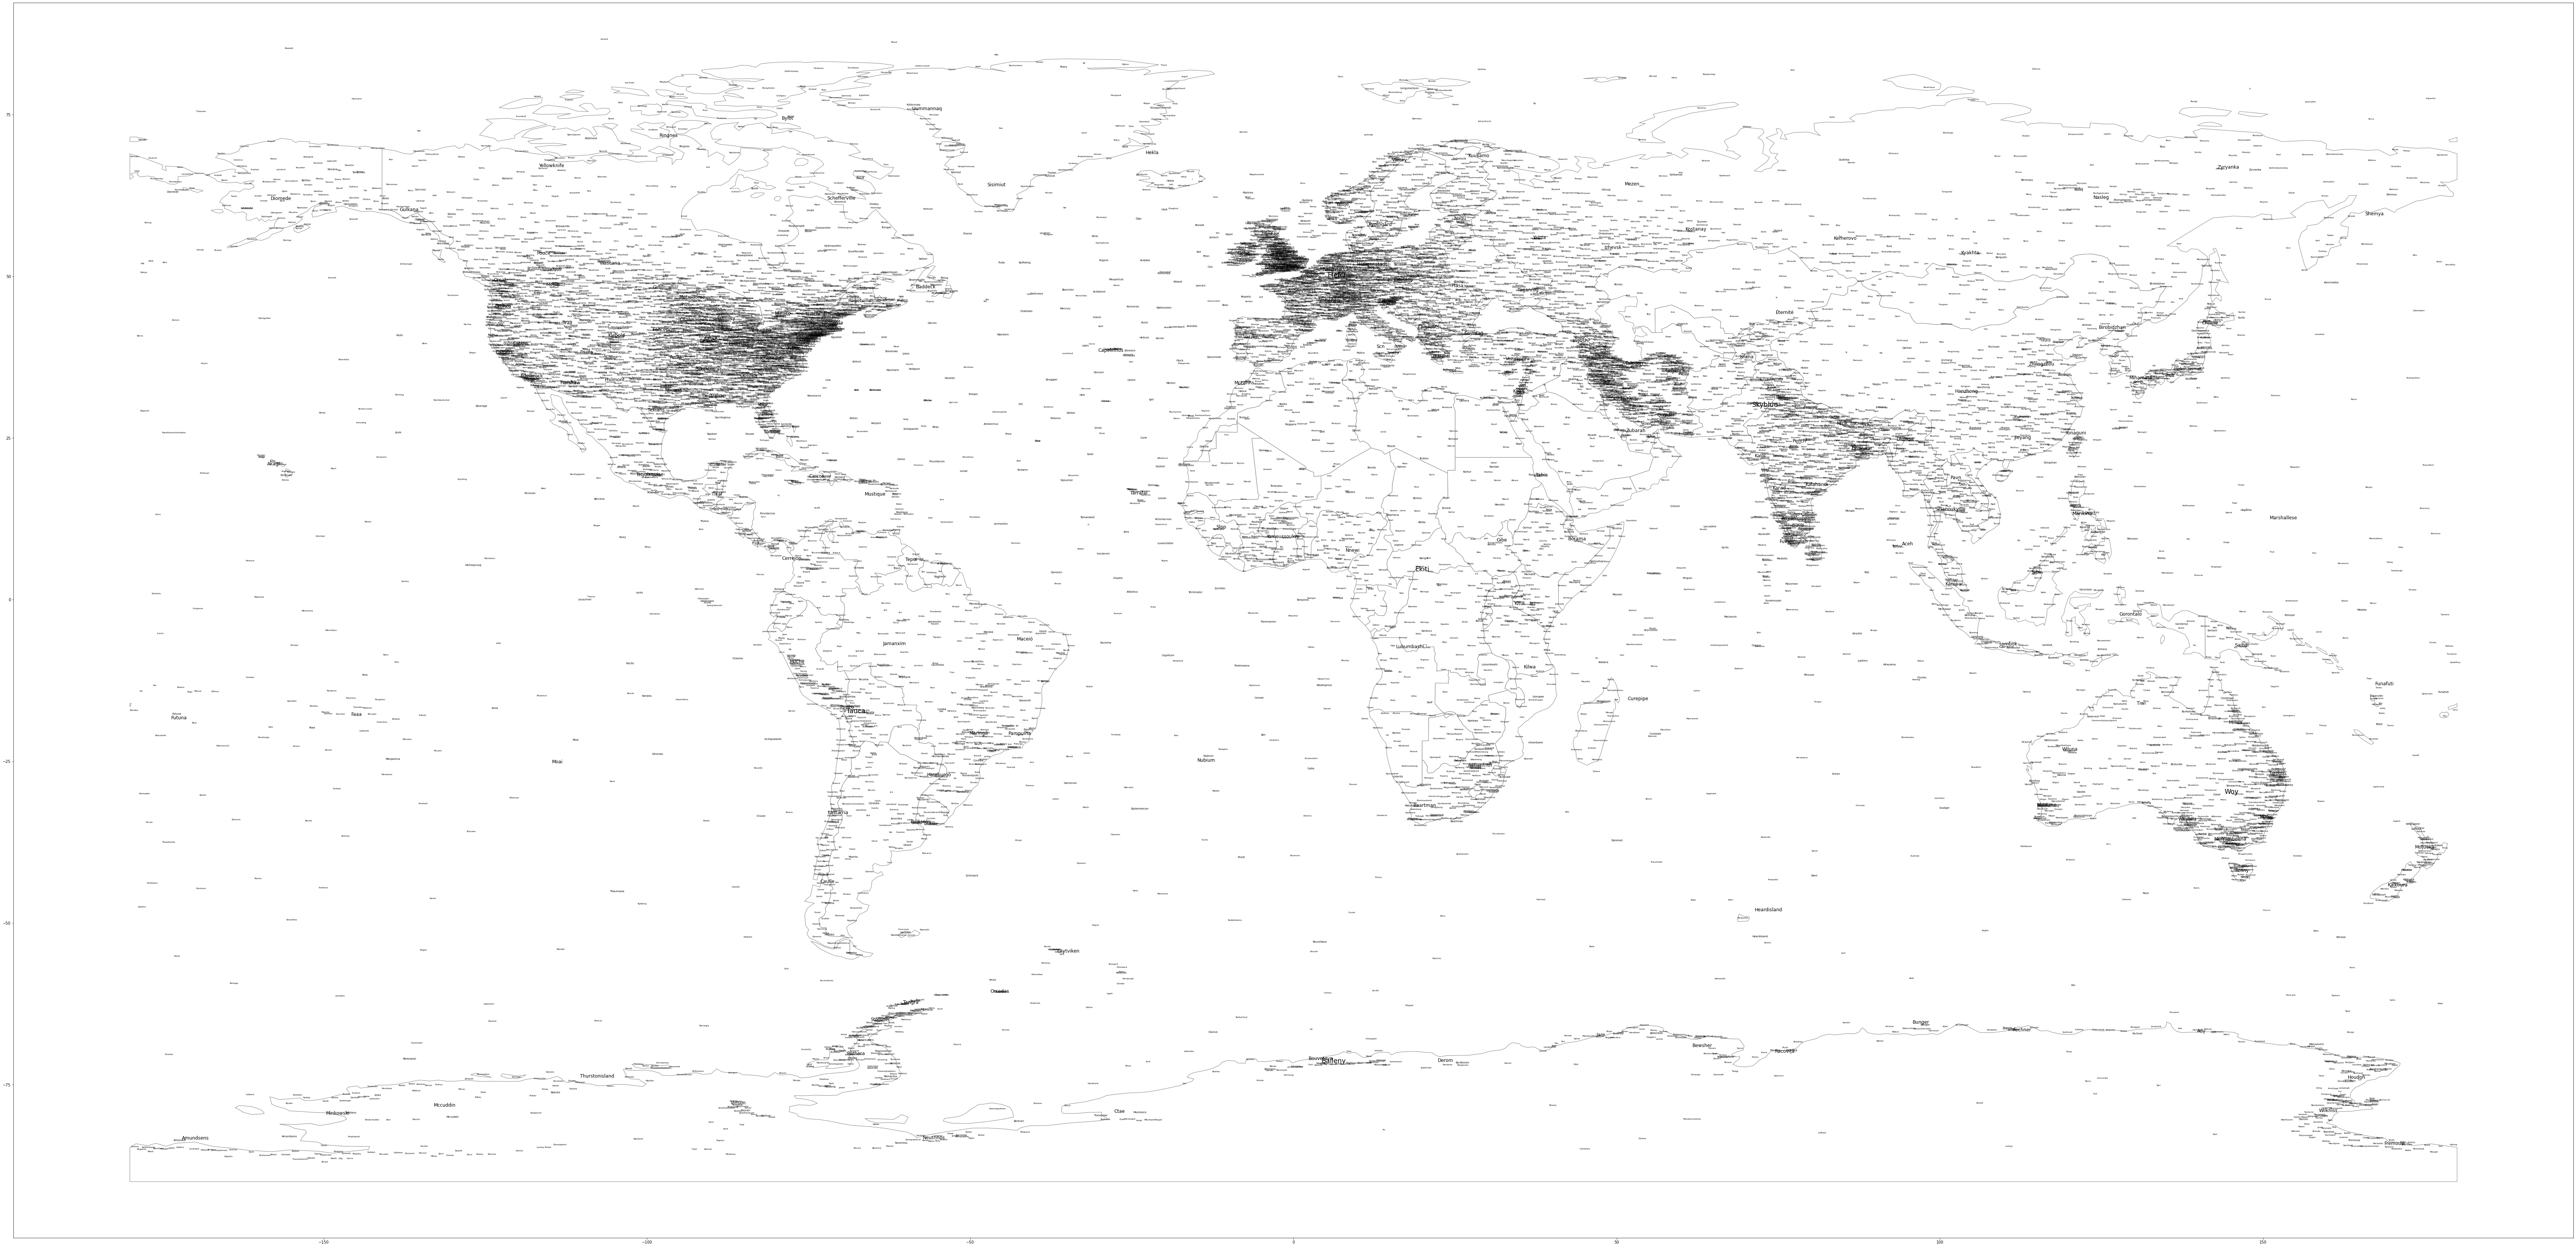

In [12]:
utils.plot_cluster_labels(cluster_labels, centers, fname=scratch_folder/'test_map.png', figsize=(120,80))

In [13]:
took = time.time() - pipeline_start
if took < 60:
    print("pipeline took", round(took, 2), "seconds")
elif took < 3600:
    print("pipeline took", round(took/60, 2), "minutes")
else:
    print("pipeline took", round(took/60/60, 2), "hours")

pipeline took 1.07 hours


In [16]:
gdf.article.unique()

array(['Lemybrien', 'Gmina Babice', 'Paval, Iran', ...,
       'Lexington, Oregon', 'Mosjøen Station', 'Media, Illinois'],
      dtype=object)